# Prediction
After the exploratory data analysis, a prediction will be made.
The folowing steps for this prediction:
1. Preprocessing - Handle missing data, Feature engineering.
2. Predictions - predicting with validation data and then with test data, metrics.
## 📚

In [359]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

#pipeline tools
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from pipelinehelper import PipelineHelper
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#plotly
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

## Baseline 1: Basic approach

### Decisions:
* **Preprocessing:**
    1. **Missing data:** **Categoric** - fill with most frequent. **Discrete** - fill with most frequent. **Continuous** - fill with median.               
    2. **Feature Engineering**: only categoric labels, one hot encoding.
* **Model training** - using cross validation in validation data on a simple decision tree model.
* **Model testing** - train on whole train + validation set and use test data for results.

**Preprocessing**

In [360]:
# Preprocessing for continuous data
contiuous_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='most_frequent')),
('oh', OneHotEncoder())
])

# Preprocessing for discrete data
disc_transformer =  SimpleImputer(strategy='median')    

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', contiuous_transformer, Continuous+["LOAN"]),
        ('cat', categorical_transformer, Cats),
        ('disc', disc_transformer, Discrete)
    ])

**Model**

In [361]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state = 42)

**Validation Preduction**

In [362]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
# Bundle preprocessing and modeling code in a pipeline
Baseline1 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
Baseline1.fit(X_train2, y_train2)

# Preprocessing of validation data, get predictions
b1_val_preds = Baseline1.predict(X_val)

# Evaluate the model
b1_val_score = accuracy_score(y_val, b1_val_preds)
b1_val_auc = roc_auc_score(y_val, b1_val_preds)
b1_val_f1 = f1_score(y_val, b1_val_preds)

print('accuracy score:', b1_val_score)
print("roc auc score: ",b1_val_auc)
print("f1 score: ",b1_val_f1)

accuracy score: 0.8582214765100671
roc auc score:  0.7699598410287355
f1 score:  0.6515463917525772


In [363]:
from sklearn.model_selection import cross_val_score
CV = cross_val_score(Baseline1, X_train, y_train, cv=5)
print(f"validation accuracy on 5 fold cross validation: {CV}")
print(f"validation mean accuracy: {CV.mean()}")

validation accuracy on 5 fold cross validation: [0.88155136 0.87002096 0.86792453 0.86883526 0.85729276]
validation mean accuracy: 0.869124974427


**Test Preduction**

In [364]:
Baseline1.fit(X_train, y_train)
b1_test_preds = Baseline1.predict(X_test)
b1_test_score = accuracy_score(y_test, b1_test_preds)
b1_test_auc = roc_auc_score(y_test, b1_test_preds)
b1_test_f1 = f1_score(y_test, b1_test_preds)
print('test accuracy score:', b1_test_score)
print("test roc auc score: ",b1_test_auc)
print("f1 score: ",b1_test_f1)

test accuracy score: 0.8548657718120806
test roc auc score:  0.7840731920783212
f1 score:  0.6679462571976968


**Area Under Curve plot**
 
 Information in Roc Curve is available [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

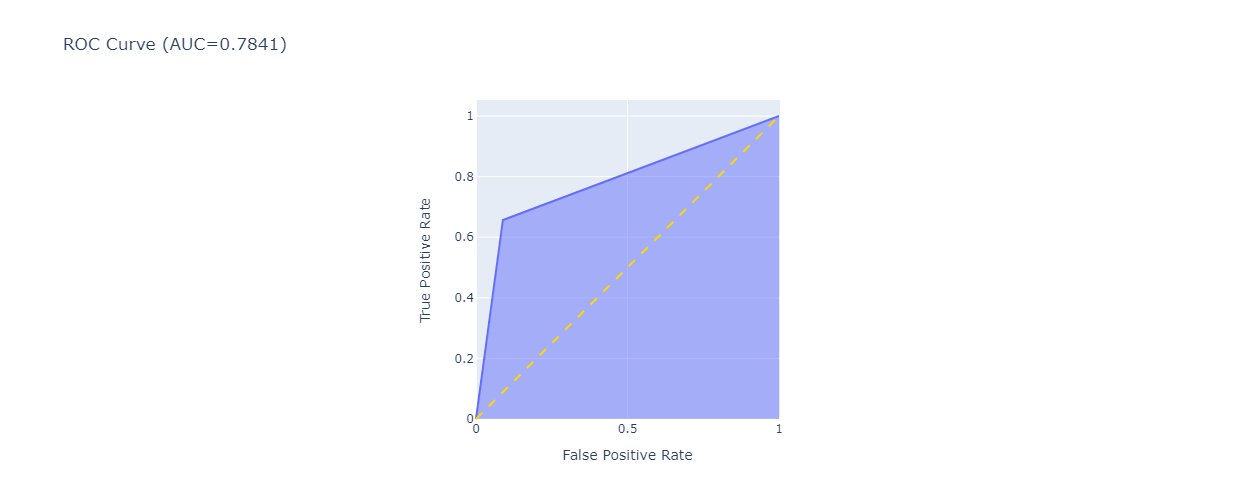

In [365]:
import plotly.express as px
from sklearn.metrics import roc_curve, auc
y_score = Baseline1.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(color="gold",dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [366]:
from sklearn.metrics import classification_report
print(pd.crosstab(y_test, b1_test_preds, rownames=["Actual"], colnames=["Predicted"]))
print(f"\n{classification_report(y_test, b1_test_preds)}")

Predicted    0    1
Actual             
0          845   82
1           91  174

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       927
           1       0.68      0.66      0.67       265

    accuracy                           0.85      1192
   macro avg       0.79      0.78      0.79      1192
weighted avg       0.85      0.85      0.85      1192



### Baseline 1 Summary
The model was cross validated 5 times and tested 1 time, `random_state=42` was inserted to fix results (both splits and model):
* **raw accuracy**: validation set had an impressive score of 85.82%, test set had 85.49% which is slightly lower but expected (no overfitting). cross validation reached 86.9%.
* **auc**: validation set had a score of 0.769, test set had 0.7841 which is higher.
* **f1 score**: validation set had a score of 0.6515, test set had 0.668 which is higher.

The baseline is saved for comparison as a pandas dataframe: 

In [367]:
Baseline1 = pd.DataFrame({"val_acc": b1_val_score,"val_auc": b1_val_auc,"val_f1": b1_val_f1,
                          "test_acc": b1_test_score,"test_auc": b1_test_auc,"test_f1": b1_test_f1}, index=["Baseline1"])
Baseline1

,val_acc,val_auc,val_f1,test_acc,test_auc,test_f1
Baseline1,0.858221,0.76996,0.651546,0.854866,0.784073,0.667946


## Baseline 2: Scaling parameters and tuning hyper parameters

### Decisions:
* **Preprocessing:**
    1. **Missing data:** **Categoric** - fill with most frequent. **Discrete** - fill with most frequent. **Continuous** - fill with median.               
    2. **Feature Engineering**: categoric labels - one hot encoding, continuous parameters: standart scaling (z-score).
* **Model training** - using grid search in validation data on a decision tree model for maximizing "accuracy".
* **Model testing** - train on whole train + validation set and use test data for results.

**Preprocessing**

In [392]:
from sklearn.preprocessing import StandardScaler

# Preprocessing for continuous data
contiuous_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='most_frequent')),
('oh', OneHotEncoder())
])

# Preprocessing for discrete data
disc_transformer = SimpleImputer(strategy='median')    

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', contiuous_transformer, Continuous+["LOAN"]),
        ('cat', categorical_transformer, Cats),
        ('disc', disc_transformer, Discrete)
    ])

In [394]:
model = DecisionTreeClassifier()

In [396]:
Baseline2 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])
Baseline2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MORTDUE', 'VALUE', 'CLAGE',
                                                   'DEBTINC', 'LOAN']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oh',
                                                                   OneHotEncoder())]),
         

In [397]:
from sklearn.model_selection import GridSearchCV
hyperparameters = {"estimator__model__min_samples_leaf":[2] }
clf = GridSearchCV(Baseline2, hyperparameters)                   

In [398]:
clf.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__preprocessor', 'estimator__model', 'estimator__preprocessor__n_jobs', 'estimator__preprocessor__remainder', 'estimator__preprocessor__sparse_threshold', 'estimator__preprocessor__transformer_weights', 'estimator__preprocessor__transformers', 'estimator__preprocessor__verbose', 'estimator__preprocessor__num', 'estimator__preprocessor__cat', 'estimator__preprocessor__disc', 'estimator__preprocessor__num__memory', 'estimator__preprocessor__num__steps', 'estimator__preprocessor__num__verbose', 'estimator__preprocessor__num__imputer', 'estimator__preprocessor__num__scaler', 'estimator__preprocessor__num__imputer__add_indicator', 'estimator__preprocessor__num__imputer__copy', 'estimator__preprocessor__num__imputer__fill_value', 'estimator__preprocessor__num__imputer__missing_values', 'estimator__preprocessor__num__imputer__strategy', 'estimator__preprocessor__num__imputer__verbose', 'es

In [400]:
# Fit and tune model
#clf.fit(X_train, y_train)